In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from sklearn.svm import SVC

import numpy as np
import matplotlib.pyplot as plt

import os
from datetime import datetime
from math import log
from copy import deepcopy

%matplotlib inline

## 2. Viseslojna klasifikacija

In [34]:
class Random2DGaussian:
    """
    Random bivariate normal distribution sampler.

    Hardwired parameters:
        horizontal_min, horizontal_max: horizontal range for the mean
        vertical_min, vertical_max: vertical range for the mean
        scale: controls the covariance range

    Methods:
        __init__: creates a new distribution
        get_sample(n): samples n datapoints
    """

    horizontal_min = 0
    horizontal_max = 10
    vertical_min = 0
    vertical_max = 10
    scale = 5

    def __init__(self):
        horizontal_range, vertical_range = self.horizontal_max - self.horizontal_min, self.vertical_max - self.vertical_min
        mean = (self.horizontal_min, self.vertical_min)
        mean += np.random.random_sample(2) * (horizontal_range, vertical_range)

        # Variances for principle directions (horizontal/vertical)
        eigvals = np.random.random_sample(2)
        eigvals *= (horizontal_range / self.scale, vertical_range / self.scale)
        eigvals **= 2

        # Pick random rotation [0, 1> * 2pi = [0, 2pi>
        theta = np.random.random_sample() * np.pi * 2
        R = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])

        # Covariance matrix
        Sigma = R.T @ np.diag(eigvals) @ R

        self.get_sample = lambda n: np.random.multivariate_normal(mean, Sigma, n)

# One Gaussian source per class
def sample_gauss_2d(num_classes, num_samples_per_class):
    # Create Gaussians
    Gs, ys = [], []
    for i in range(num_classes):
        Gs.append(Random2DGaussian())
        ys.append(i)

    # Sample dataset
    X = np.vstack([G.get_sample(num_samples_per_class) for G in Gs])
    y = np.hstack([[y] * num_samples_per_class for y in ys])
    return X, y

# One class can have multiple Gaussian components
def sample_gmm_2d(num_components, num_classes, num_samples_per_class):
    # Create Gaussian components and assign them random class idx
    Gs, ys = [], []
    for _ in range(num_components):
        Gs.append(Random2DGaussian())
        ys.append(np.random.randint(num_classes))

    # Sample dataset
    X = np.vstack([G.get_sample(num_samples_per_class) for G in Gs])
    y = np.hstack([[y] * num_samples_per_class for y in ys])
    return X, y


def graph_surface(function, rect, offset=0.5, width=256, height=256):
  """Creates a surface plot (visualize with plt.show)

  Arguments:
    function: surface to be plotted
    rect:     function domain provided as:
              ([x_min,y_min], [x_max,y_max])
    offset:   the level plotted as a contour plot

  Returns:
    None
  """

  lsw = np.linspace(rect[0][1], rect[1][1], width)
  lsh = np.linspace(rect[0][0], rect[1][0], height)
  xx0,xx1 = np.meshgrid(lsh, lsw)
  grid = np.stack((xx0.flatten(),xx1.flatten()), axis=1)

  #get the values and reshape them
  values=function(grid).reshape((width,height))

  # fix the range and offset
  delta = offset if offset else 0
  maxval=max(np.max(values)-delta, - (np.min(values)-delta))

  # draw the surface and the offset
  plt.pcolormesh(xx0, xx1, values,
     vmin=delta-maxval, vmax=delta+maxval, cmap="jet")

  if offset != None:
    plt.contour(xx0, xx1, values, colors='black', levels=[offset])

def graph_data(X,Y_, Y, special=[]):
  """Creates a scatter plot (visualize with plt.show)

  Arguments:
      X:       datapoints
      Y_:      groundtruth classification indices
      Y:       predicted class indices
      special: use this to emphasize some points

  Returns:
      None
  """
  # colors of the datapoint markers
  palette=([0.5,0.5,0.5], [1,1,1], [0.2,0.2,0.2])
  colors = np.tile([0.0,0.0,0.0], (Y_.shape[0],1))
  for i in range(len(palette)):
    colors[Y_==i] = palette[i]

  # sizes of the datapoint markers
  sizes = np.repeat(20, len(Y_))
  sizes[special] = 40

  # draw the correctly classified datapoints
  good = (Y_==Y)
  plt.scatter(X[good,0],X[good,1], c=colors[good],
              s=sizes[good], marker='o', edgecolors='black')

  # draw the incorrectly classified datapoints
  bad = (Y_!=Y)
  plt.scatter(X[bad,0],X[bad,1], c=colors[bad],
              s=sizes[bad], marker='s', edgecolors='black')

def class_to_onehot(Y):
  Yoh = np.zeros((len(Y), max(Y) + 1))
  Yoh[range(len(Y)), Y] = 1
  return Yoh

def eval_perf_binary(Y, Y_):
  tp = sum(np.logical_and(Y == Y_, Y_ == True))
  fn = sum(np.logical_and(Y != Y_, Y_ == True))
  tn = sum(np.logical_and(Y == Y_, Y_ == False))
  fp = sum(np.logical_and(Y != Y_, Y_ == False))
  recall = tp / (tp + fn)
  precision = tp / (tp + fp)
  accuracy = (tp + tn) / (tp + fn + tn + fp)
  return accuracy, recall, precision



def eval_perf_multi(Y, Y_):
    """
    Evaluate performance of multiclass classification

    Parameters
    ----------
        Y: predicted class indices, np.array of shape Nx1
        Y_: ground truth indices, np.array of shape Nx1

    Returns
    -------
        M: confusion_matrix
        accuracy, precision, recall: metrics

    """

    Y_ = Y_.reshape(-1)
    Y = Y.reshape(-1)
    num_classes = np.max(Y_) + 1
    M = np.zeros((num_classes, num_classes))
    for y_, y in zip(Y_, Y):
        M[y_][y] += 1

    accuracy = np.trace(M) / np.sum(M)
    precision = np.divide(np.diag(M), np.sum(M, axis=0), where=np.sum(M, axis=0) != 0)
    recall = np.divide(np.diag(M), np.sum(M, axis=1), where=np.sum(M, axis=1) != 0)

    return M.astype(np.int32), accuracy, recall, precision

def eval_AP(ranked_labels):
  """Recovers AP from ranked labels"""

  n = len(ranked_labels)
  pos = sum(ranked_labels)
  neg = n - pos

  tp = pos
  tn = 0
  fn = 0
  fp = neg

  sumprec=0
  for x in ranked_labels:
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    if x:
      sumprec += precision

    tp -= x
    fn += x
    fp -= not x
    tn += not x

  return sumprec / pos

def myDummyDecision(X):
  scores = X[:,0] + X[:,1] - 5
  return scores

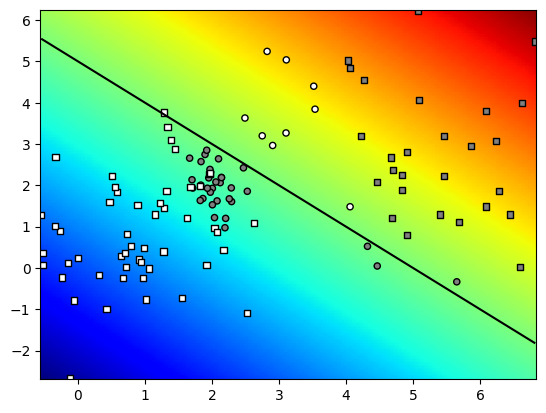

In [3]:
np.random.seed(100)
# get data
X,Y_ = sample_gmm_2d(4, 2, 30)
# X,Y_ = sample_gauss_2d(2, 100)

# get the class predictions
Y = myDummyDecision(X)>0.5

# graph the decision surface
rect=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(myDummyDecision, rect, offset=0)

# graph the data points
graph_data(X, Y_, Y, special=[])

plt.show()

In [4]:
np.random.seed(100)
K, C, N, h = 6, 2, 10, 5
X, Y_ = sample_gmm_2d(K, C, N)

In [5]:
def softmax(scores):
    max_scores = np.max(scores, axis=1, keepdims=True)
    shifted_scores = scores - max_scores
    exp_scores = np.exp(shifted_scores)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def fcann2_train(X, Y_, param_niter=1e5, param_delta=0.05, param_lambda=1e-3):
    num_classes = np.max(Y_) + 1
    h = 5
    W1 = np.random.randn(X.shape[1], h)
    b1 = np.zeros((h,))
    W2 = np.random.randn(h, num_classes)
    b2 = np.zeros((num_classes,))

    Y_oh = class_to_onehot(Y_)

    for i in range(int(param_niter)):
        # Forward
        s1 = X @ W1 + b1
        h1 = np.maximum(s1, 0)
        s2 = h1 @ W2 + b2

        # Loss
        P = softmax(s2)
        log_P = np.log(P)
        l2_reg = 0.5 * param_lambda * (np.sum(W1**2) + np.sum(W2**2))
        loss = -1 / X.shape[0] * np.sum(log_P[np.arange(X.shape[0]), Y_]) + l2_reg

        # Backward
        dL_ds2 = (P - Y_oh) / X.shape[0]
        dL_dW2 =  h1.T @ dL_ds2 + param_lambda * W2
        dL_db2 = dL_ds2.sum(0)
        dL_dh1 = dL_ds2 @ W2.T
        dL_ds1 = dL_dh1 * (s1 > 0)
        dL_dW1 = X.T @ dL_ds1 + param_lambda * W1
        dL_db1 = dL_ds1.sum(0)

        # Update GD
        W1 = W1 - param_delta * dL_dW1
        b1 = b1 - param_delta * dL_db1
        W2 = W2 - param_delta * dL_dW2
        b2 = b2 - param_delta * dL_db2

    return W1, b1, W2, b2

def fcann2_classify(X, W1, b1, W2, b2):
    s1 = X @ W1 + b1
    h1 = np.maximum(s1, 0)
    s2 = h1 @ W2 + b2
    return s2

def fcann2_decfun(W1, b1, W2, b2):
    def classify(X):
        scores = fcann2_classify(X, W1, b1, W2, b2)
        return softmax(scores)[:, 1]

    return classify

In [ ]:
W1, b1, W2, b2 = fcann2_train(X, Y_)
scores = fcann2_classify(X, W1, b1, W2, b2)
centered_scores = scores - scores[:, 0].reshape(-1, 1)
Y = softmax(scores).argmax(axis=1)
classify = fcann2_decfun(W1, b1, W2, b2)

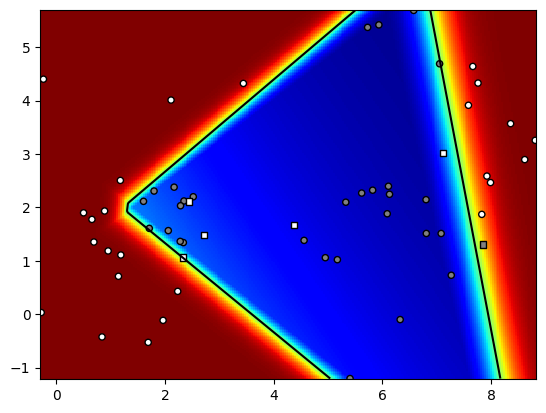

In [ ]:
rect=(np.min(X, axis=0), np.max(X, axis=0))
graph_surface(classify, rect)

# graph the data points
graph_data(X, Y_, softmax(scores).argmax(axis=1), special=[])

plt.show()

# 3. Linearna regresija

In [ ]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

#X = torch.tensor([1, 2])
#Y = torch.tensor([3, 5])
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
Y = torch.tensor([3, 5, 7, 9], dtype=torch.float32)

# optimizacijski postupak: gradijentni spust
optimizer = optim.SGD([a, b], lr=0.1)

for i in range(1000):
    # afin regresijski model
    Y_ = a*X + b

    diff = (Y-Y_)

    # kvadratni gubitak
    loss = torch.mean(diff**2)

    # računanje gradijenata
    loss.backward()

    # korak optimizacije
    optimizer.step()

    # Postavljanje gradijenata na nulu
    optimizer.zero_grad()
    if i % 100 == 0:
        print(f'step: {i}, loss:{loss}, Y_:{Y_}, a:{a}, b {b}')

step: 0, loss:27.390029907226562, Y_:tensor([0.4460, 0.8648, 1.2835, 1.7022], grad_fn=<AddBackward0>), a:tensor([3.2770], requires_grad=True), b tensor([1.0125], requires_grad=True)
step: 100, loss:5.8091118262382224e-05, Y_:tensor([2.9877, 4.9940, 7.0004, 9.0067], grad_fn=<AddBackward0>), a:tensor([2.0062], requires_grad=True), b tensor([0.9819], requires_grad=True)
step: 200, loss:1.3306937773904792e-07, Y_:tensor([2.9994, 4.9997, 7.0000, 9.0003], grad_fn=<AddBackward0>), a:tensor([2.0003], requires_grad=True), b tensor([0.9991], requires_grad=True)
step: 300, loss:3.0115643312456086e-10, Y_:tensor([3.0000, 5.0000, 7.0000, 9.0000], grad_fn=<AddBackward0>), a:tensor([2.0000], requires_grad=True), b tensor([1.0000], requires_grad=True)
step: 400, loss:6.394884621840902e-13, Y_:tensor([3.0000, 5.0000, 7.0000, 9.0000], grad_fn=<AddBackward0>), a:tensor([2.0000], requires_grad=True), b tensor([1.0000], requires_grad=True)
step: 500, loss:5.115907697472721e-13, Y_:tensor([3.0000, 5.0000, 7

In [ ]:
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
Y = torch.tensor([3, 5, 7, 9], dtype=torch.float32)
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)

In [ ]:
Y_ = a*X + b
diff = (Y-Y_)
loss = torch.mean(diff**2)
loss.retain_grad()
loss.backward()

In [ ]:
loss.grad

tensor(1.)

In [ ]:
a.grad, b.grad

(tensor([-50.4007]), tensor([-17.2477]))

In [ ]:
dL_da = -2*torch.mean(diff*X)
dL_db = -2*torch.mean(diff)

In [ ]:
dL_da, dL_db

(tensor(-50.4007, grad_fn=<MulBackward0>),
 tensor(-17.2477, grad_fn=<MulBackward0>))

In [ ]:
def gen_points(a, b, N=10):
    X = torch.rand(N)
    Y = a*X + b
    return X, Y

X, Y = gen_points(2, 2, 100)

In [ ]:
a = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
optimizer = optim.SGD([a, b], lr=0.1)

for i in range(1000):
    # afin regresijski model
    Y_ = a*X + b

    diff = (Y-Y_)

    # kvadratni gubitak
    loss = torch.mean(diff**2)

    # računanje gradijenata
    loss.backward()

    # korak optimizacije
    optimizer.step()

    # Postavljanje gradijenata na nulu
    optimizer.zero_grad()
    if i % 100 == 0:
        print(f'step: {i}, loss:{loss}, Y_:{Y_}, a:{a}, b {b}')

step: 0, loss:3.9526970386505127, Y_:tensor([1.0106, 1.1379, 1.1601, 1.1213, 1.0836, 0.9879, 1.1301, 1.0360, 1.0841,
        1.0534, 1.0599, 1.0980, 1.0623, 1.0677, 0.9999, 1.1439, 1.0922, 1.0126,
        0.9771, 0.9845, 1.0037, 1.0952, 1.1080, 1.0643, 1.0951, 1.0759, 1.0740,
        1.0388, 1.0515, 1.0479, 0.9901, 1.1081, 1.0446, 1.0793, 1.1723, 1.0166,
        1.0272, 1.0962, 1.0394, 1.1265, 1.0087, 1.0553, 1.0458, 1.0276, 1.1483,
        1.0715, 1.1634, 1.0545, 1.0252, 1.1435, 1.0788, 1.1737, 1.0807, 1.1199,
        1.0899, 0.9825, 1.1705, 1.1085, 1.1526, 1.0172, 0.9760, 1.1277, 1.1516,
        0.9760, 1.0557, 1.0534, 1.0030, 1.0703, 1.0817, 1.1409, 0.9755, 0.9907,
        1.0313, 1.0969, 1.0733, 1.1007, 1.0549, 1.1606, 1.0295, 1.1651, 1.0483,
        1.1517, 1.1444, 0.9965, 1.0908, 1.1618, 1.1380, 0.9836, 1.0660, 1.0594,
        1.0090, 1.1071, 1.0379, 1.1292, 0.9919, 0.9833, 0.9931, 1.1110, 1.0645,
        1.1621], grad_fn=<AddBackward0>), a:tensor([0.4294], requires_grad=True), b

## 4. Logisticka regresija

In [ ]:
class PTLogreg(nn.Module):
    def __init__(self, D, C):
        """Arguments:
            - D: dimensions of each datapoint
            - C: number of classes
        """

        # inicijalizirati parametre (koristite nn.Parameter):
        # imena mogu biti self.W, self.b
        # ...
        super().__init__()
        self.W = nn.Parameter(torch.randn((D, C), dtype=torch.float32))
        self.b = nn.Parameter(torch.zeros(C))


    def forward(self, X):
        # unaprijedni prolaz modela: izračunati vjerojatnosti
        #   koristiti: torch.mm, torch.softmax
        # ...
        s = torch.mm(X, self.W) + self.b
        return torch.softmax(s, dim=1)

    def get_loss(self, X, Yoh_):
        # formulacija gubitka
        #   koristiti: torch.log, torch.exp, torch.sum
        #   pripaziti na numerički preljev i podljev
        # ...
        logits = torch.mm(X, self.W) + self.b
        exp_shifted = torch.exp(logits - torch.max(logits, dim=1, keepdims=True).values)
        probs = exp_shifted / exp_shifted.sum(dim=1, keepdims=True)
        log_probs = probs.log()
        loss = -torch.sum(log_probs * Yoh_) / X.shape[0]
        return loss

In [ ]:
def train(model, X, Yoh_, param_niter, param_delta, param_lambda=0.0):
    """Arguments:
        - X: model inputs [NxD], type: torch.Tensor
        - Yoh_: ground truth [NxC], type: torch.Tensor
        - param_niter: number of training iterations
        - param_delta: learning rate
    """

    # inicijalizacija optimizatora
    # ...
    optimizer = optim.SGD(model.parameters(), lr=param_delta)

    # petlja učenja
    # ispisujte gubitak tijekom učenja
    # ...
    show_freq = param_niter // 10
    for i in range(param_niter):
        optimizer.zero_grad()
        l2_reg = param_lambda * torch.sum(model.W**2)
        loss = model.get_loss(X, Yoh_) + l2_reg
        loss.backward()
        optimizer.step()
        if i % show_freq == show_freq - 1:
            print(f'step: {i}, loss:{loss}')

def eval(model, X):
    """Arguments:
        - model: type: PTLogreg
        - X: actual datapoints [NxD], type: np.array
        Returns: predicted class probabilites [NxC], type: np.array
    """
    # ulaz je potrebno pretvoriti u torch.Tensor
    # izlaze je potrebno pretvoriti u numpy.array
    # koristite torch.Tensor.detach() i torch.Tensor.numpy()
    X_torch = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        probs = model.forward(X_torch)
    return probs.detach().numpy()

In [ ]:
np.random.seed(100)
torch.manual_seed(100)
X, Y = sample_gauss_2d(3, 100)
D = X.shape[1]
C = np.max(Y) + 1
logreg = PTLogreg(D, C)
X_torch = torch.tensor(X, dtype=torch.float32)
Y_torch = torch.tensor(Y, dtype=torch.float32)
Yoh_torch = torch.tensor(class_to_onehot(Y), dtype=torch.float32)

In [ ]:
logreg.get_loss(X_torch, Yoh_torch)

tensor(7.9786, grad_fn=<DivBackward0>)

In [ ]:
train(logreg, X_torch, Yoh_torch, 1000, 0.5, 1e-3)

step: 99, loss:2.911013126373291
step: 199, loss:1.0812146663665771
step: 299, loss:0.5162795782089233
step: 399, loss:0.11523381620645523
step: 499, loss:0.11873036623001099
step: 599, loss:0.10562735050916672
step: 699, loss:0.10256636142730713
step: 799, loss:0.10135715454816818
step: 899, loss:0.10030267387628555
step: 999, loss:0.09936900436878204


In [ ]:
def logreg_decfun(model):
    def classify(X):
        probs = eval(model, X)
        return probs.argmax(axis=1)

    return classify

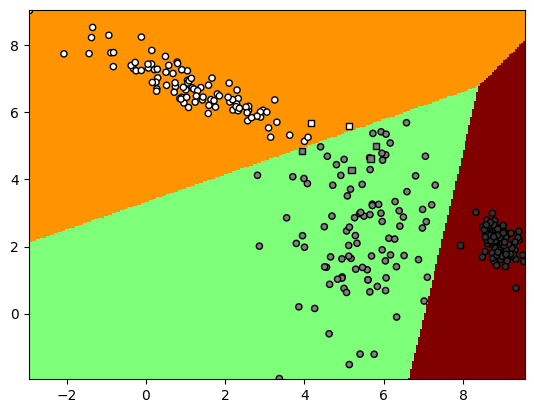

In [ ]:
probs = eval(logreg, X)
Y_ = probs.argmax(axis=1).reshape(-1, 1)
decfun = logreg_decfun(logreg)
bbox = (np.min(X, axis=0), np.max(X, axis=0))

#graph_surface(decfun, bbox, 0.5)
graph_surface(decfun, bbox, None)
graph_data(X, Y_.reshape(-1), Y.reshape(-1))
plt.show()

## 5. Konfigurabilni duboki modeli

In [ ]:
class PTDeep(nn.Module):
    def __init__(self, layers, activation=nn.ReLU):
        super().__init__()
        self.activation = activation()
        self.params = nn.ParameterDict()
        for i, (in_dim, out_dim) in enumerate(zip(layers, layers[1:])):
            self.params[f"W{i}"] = nn.Parameter(torch.randn((in_dim, out_dim), dtype=torch.float32))
            self.params[f"b{i}"] = nn.Parameter(torch.zeros(out_dim))

    def forward(self, X):
        num_layers = len(self.params) // 2
        for i in range(num_layers):
            W = self.params[f"W{i}"]
            b = self.params[f"b{i}"]
            X = torch.matmul(X, W) + b
            if i < num_layers - 1:
                X = self.activation(X)
        return torch.softmax(X, dim=1)

    def get_loss(self, X, Yoh_):
        probs = self.forward(X)
        loss = -torch.sum(Yoh_ * torch.log(probs + 1e-12)) / X.shape[0]
        return loss

    def count_params(self):
        total = 0
        for name, param in self.named_parameters():
            print(f"{name} ... {list(param.shape)}, numel={param.numel()}")
            total += param.numel()
        return total

In [ ]:
def train(model, X, Yoh_, param_niter, param_delta, param_lambda=0.0):
    """Arguments:
        - X: model inputs [NxD], type: torch.Tensor
        - Yoh_: ground truth [NxC], type: torch.Tensor
        - param_niter: number of training iterations
        - param_delta: learning rate
    """
    # inicijalizacija optimizatora
    # ...
    optimizer = optim.SGD(model.parameters(), lr=param_delta)

    # petlja učenja
    # ispisujte gubitak tijekom učenja
    # ...
    show_freq = param_niter // 10
    num_layers = len(model.params) // 2
    for i in range(param_niter):
        optimizer.zero_grad()
        l2_reg = 0.0
        for j in range(num_layers):
            l2_reg += torch.sum(model.params[f"W{j}"]**2)
        loss = model.get_loss(X, Yoh_) + param_lambda * l2_reg
        loss.backward()
        optimizer.step()
        if i % show_freq == show_freq - 1:
            print(f"Step: {i}, Loss: {loss}")

def eval(model, X):
    """Arguments:
        - model: type: PTDeep
        - X: actual datapoints [NxD], type: np.array
        Returns: predicted class probabilites [NxC], type: np.array
    """
    # ulaz je potrebno pretvoriti u torch.Tensor
    # izlaze je potrebno pretvoriti u numpy.array
    # koristite torch.Tensor.detach() i torch.Tensor.numpy()
    X_torch = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        probs = model.forward(X_torch)
    return probs.detach().numpy()

def deep_decfun(model):
    def classify(X):
        probs = eval(model, X)
        return probs.argmax(axis=1)

    return classify

In [ ]:
np.random.seed(100)
torch.manual_seed(100)
#X, Y = sample_gauss_2d(3, 100)
#X, Y = sample_gmm_2d(4, 2, 40)
X, Y_ = sample_gmm_2d(6, 2, 10)
X_torch = torch.tensor(X, dtype=torch.float32)
Y_torch = torch.tensor(Y_, dtype=torch.float32)
Yoh_torch = torch.tensor(class_to_onehot(Y_), dtype=torch.float32)

In [ ]:
dims = [2, 10, 10, 2]
ptd = PTDeep(dims)
ptd.count_params()

params.W0 ... [2, 10], numel=20
params.b0 ... [10], numel=10
params.W1 ... [10, 10], numel=100
params.b1 ... [10], numel=10
params.W2 ... [10, 2], numel=20
params.b2 ... [2], numel=2


162

In [ ]:
ptd.get_loss(X_torch, Yoh_torch)

tensor(10.9352, grad_fn=<DivBackward0>)

In [ ]:
train(ptd, X_torch, Yoh_torch, 10000, 0.1, 1e-4)

Step: 999, Loss: 0.20764562487602234
Step: 1999, Loss: 0.4416748881340027
Step: 2999, Loss: 0.09636234492063522
Step: 3999, Loss: 0.08445068448781967
Step: 4999, Loss: 0.13069017231464386
Step: 5999, Loss: 0.0879373773932457
Step: 6999, Loss: 0.06462249904870987
Step: 7999, Loss: 0.058543860912323
Step: 8999, Loss: 0.05291466414928436
Step: 9999, Loss: 0.05434548109769821


In [ ]:
ptd.get_loss(X_torch, Yoh_torch)

tensor(0.0278, grad_fn=<DivBackward0>)

Ukupna tocnost: 0.9833333333333333, Odziv: [1.         0.96666667], Preciznost: [0.96774194 1.        ]


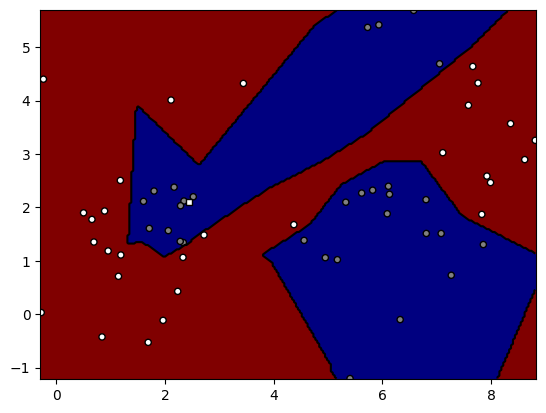

In [ ]:
probs = eval(ptd, X)
Y = probs.argmax(axis=1).reshape(-1, 1)

# ispiši performansu (preciznost i odziv po razredima)
M, accuracy, recall, precision = eval_perf_multi(Y, Y_)
print(f"Ukupna tocnost: {accuracy}, Odziv: {recall}, Preciznost: {precision}")

# # iscrtaj rezultate, decizijsku plohu
decfun = deep_decfun(ptd)
bbox = (np.min(X, axis=0), np.max(X, axis=0))

graph_surface(decfun, bbox, 0.5)
#graph_surface(decfun, bbox, None)
graph_data(X, Y_.reshape(-1), Y.reshape(-1))
plt.show()

## 6. Usporedba s jezgrenim SVM-om

In [ ]:
class KSVMWrap:
    def __init__(self, X, Y_, param_svm_c=1, param_svm_gamma='auto'):
        self.model = SVC(C=param_svm_c, gamma=param_svm_gamma, probability=True)
        self.model.fit(X, Y_)

    def predict(self, X):
        return self.model.predict(X)

    def get_scores(self, X):
        return self.model.decision_function(X)

    @property
    def support(self):
        return self.model.support_

# def svm_decfun(Xgrid):
#     return svm_model.predict(Xgrid)
def svm_decfun(model):
    def classify(X):
        return model.predict(X)
    return classify

In [ ]:
np.random.seed(100)
X, Y_ = sample_gmm_2d(6, 2, 10)
svm_model = KSVMWrap(X, Y_, param_svm_c=1, param_svm_gamma='auto')

Ukupna tocnost: 0.9333333333333333, Odziv: [1.         0.86666667], Preciznost: [0.88235294 1.        ]


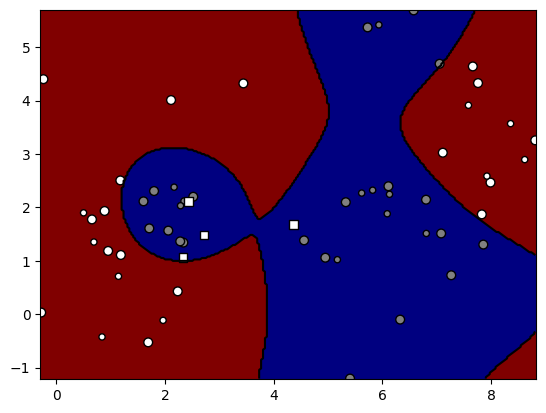

In [ ]:
Y = svm_model.predict(X)
M, accuracy, recall, precision = eval_perf_multi(Y, Y_)
print(f"Ukupna tocnost: {accuracy}, Odziv: {recall}, Preciznost: {precision}")

# scores = svm_model.get_scores(X)  # shape (N,) if binary
# sorted_indices = np.argsort(-scores)        # descending
# ranked_labels = (Y_[sorted_indices] == 1)  # True if class=1
# AP = eval_AP(ranked_labels)
# print("Average precision:", AP)

bbox = (np.min(X, axis=0), np.max(X, axis=0))
decfun = svm_decfun(svm_model)
graph_surface(decfun, bbox, offset=0.5)
sv_indices = svm_model.support
graph_data(X, Y_, Y, special=sv_indices)
plt.show()

## 7. MNIST

In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [9]:
class Linear(nn.Module):
    def __init__(self, in_features, out_features, device="cpu"):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features, device=device) * 0.01)
        self.bias = nn.Parameter(torch.zeros(out_features, device=device))

    def forward(self, x):
        return x @ self.weight.T + self.bias

class FCN(nn.Module):
    def __init__(self, layers, activation=nn.ReLU, device="cpu"):
        super().__init__()
        self._layers = layers
        self.activation = activation()
        self.flat = nn.Flatten()
        self.layers = nn.Sequential()

        if device == "cuda" and torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

        for i, (dim_in, dim_out) in enumerate(zip(layers, layers[1:])):
            self.layers.add_module(f"fc{i}", Linear(dim_in, dim_out, device=self.device))
            if i != len(layers) - 2:
                self.layers.add_module(f"act{i}", activation())

        self.layers.append(nn.Softmax(dim=1))

    def forward(self, X):
        if isinstance(X, np.ndarray):
            X = torch.tensor(X, dtype=torch.float32, device=self.device)
        X = self.flat(X)
        X = self.layers(X)
        return X

    def get_loss(self, X, Yoh_):
        probs = self.forward(X)
        loss = -torch.sum(Yoh_ * torch.log(probs + 1e-12)) / X.shape[0]
        return loss

    def count_params(self):
        total = 0
        for name, param in self.named_parameters():
            print(f"{name} ... {list(param.shape)}, numel={param.numel()}")
            total += param.numel()
        return total

    @torch.no_grad()
    def predict(self, X):
        probs = self.forward(X)
        preds = probs.argmax(axis=1)
        return preds

In [28]:
def save_state(filename, model, optimizer, train_loss_history, val_loss_history):
    state = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history
    }

    dirname = os.path.dirname(filename)
    if not os.path.exists(dirname):
        os.makedirs(dirname)
    torch.save(state, filename)
    print(f"saved to {filename}")

def load_state(filename, model, optimizer):
    state = torch.load(filename)
    model.load_state_dict(state["model_state_dict"])
    optimizer.load_state_dict(state["optimizer_state_dict"])
    train_loss_history = state["train_loss_history"]
    val_loss_history = state["val_loss_history"]
    print(f"loaded from {filename}")

    return model, optimizer, train_loss_history, val_loss_history

def evaluate(model, X, Y_):
    Y = model.predict(X)
    M, accuracy, recall, precision = eval_perf_multi(Y.detach().cpu().numpy().astype(np.int32), Y_.detach().cpu().numpy().astype(np.int32))
    return M, accuracy, recall, precision

def class_to_onehot(y):
    C = y.max() + 1
    yoh = torch.zeros(y.shape[0], C, device=y.device)
    yoh[range(y.shape[0]), y] = 1
    return yoh

def load_mnist(dirname="/tmp/mnist"):
    mnist_train = torchvision.datasets.MNIST(dirname, train=True, download=True)
    mnist_test = torchvision.datasets.MNIST(dirname, train=False, download=True)

    X_train, y_train = mnist_train.data, mnist_train.targets
    X_test, y_test = mnist_test.data, mnist_test.targets
    X_train, X_test = X_train.float().div_(255.0), X_test.float().div_(255.0)

    return X_train.to(DEVICE), y_train.to(DEVICE), X_test.to(DEVICE), y_test.to(DEVICE)

def train(model, X_train, yoh_train, X_val, yoh_val, optimizer=optim.SGD, scheduler=False, epochs=10, lr=1e-4, weight_decay=1e-3, show_freq=1, batch_size=100, lr_decay=1-1e-4, seed=100, dirname=None, verbose=True):
    torch.manual_seed(seed)
    optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)
    if scheduler:
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=lr_decay)

    if batch_size == -1 or batch_size >= X_train.shape[0] or batch_size == None:
        batch_size = X_train.shape[0]

    train_loss_history, val_loss_history = [], []
    best_model = deepcopy(model)
    best_loss = float("inf")

    for i in range(epochs):
        model.train()
        shuffle_idx = torch.randperm(X_train.shape[0])
        X_train_shuffled = X_train[shuffle_idx]
        yoh_train_shuffled = yoh_train[shuffle_idx]

        for j in range(0, X_train.shape[0], batch_size):
            X_train_batch = X_train_shuffled[j:j+batch_size]
            yoh_train_batch = yoh_train_shuffled[j:j+batch_size]

            optimizer.zero_grad()
            loss = model.get_loss(X_train_batch, yoh_train_batch)
            loss.backward()

            optimizer.step()
            if scheduler:
                scheduler.step()
            train_loss_history.append(loss.item())

        with torch.no_grad():
            model.eval()
            val_loss = model.get_loss(X_val, yoh_val)
            val_loss_history.append(val_loss.item())

        if i % show_freq == 0:
            if best_loss > val_loss:
                best_loss = val_loss
                best_model = deepcopy(model)

            if verbose:
                print(f"Step: {i}/{epochs}, Train Loss: {loss:.2f}, Val Loss: {val_loss:.2f}")

    if dirname:
        checkpoint_name = f"{type(model).__name__}_{str(model._layers)[1:-1].replace(', ', '_')}"
        checkpoint_name += f"_seed={seed}_optim={type(optimizer).__name__}_epochs={epochs}_lr={lr}_weight_decay={weight_decay}"
        checkpoint_name += f"_bs={'full' if batch_size == X_train.shape[0] else batch_size}"
        checkpoint_name += f"_scheduler={type(scheduler).__name__}_lr_decay={lr_decay:.4f}" if scheduler else "_scheduler=none"
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
        checkpoint_name += f"_{timestamp}.pth"

        filename = os.path.join(dirname, checkpoint_name)
        save_state(filename, best_model, optimizer, train_loss_history, val_loss_history)

    return best_model, train_loss_history, val_loss_history

In [11]:
X_train, y_train, X_test, y_test = load_mnist()
N = X_train.shape[0]
D = X_train.shape[1] * X_train.shape[2]
C = y_train.max().add_(1).item()
h = 100
configs = [[D, C], [D, h, C], [D, h, h, C], [D, h, h, h, C]]

X_train_flat = X_train.reshape(-1, D)
X_test_flat = X_test.reshape(-1, D)
yoh_train = class_to_onehot(y_train)
yoh_test = class_to_onehot(y_test)

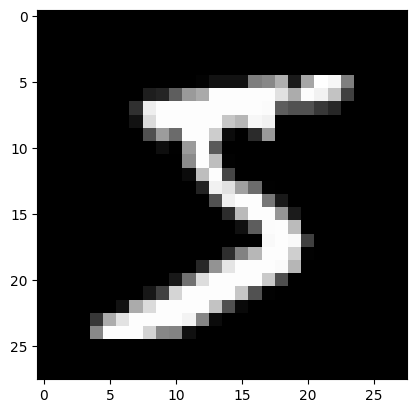

In [13]:
plt.imshow(X_train[0].detach().cpu().numpy(), cmap='gray')
plt.show()

## Part 1

In [14]:
def visualize_weights(w):
    w = w.reshape(C, 28, 28)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    for i in range(10):
        axes[i].set_title(f"Weights for digit {i}")
        axes[i].imshow(w[i], cmap="gray")
        axes[i].axis("off")

    plt.show()

Training with regularization: 0.0
Step: 0/3000, Train Loss: 2.32, Val Loss: 2.31
Step: 100/3000, Train Loss: 1.56, Val Loss: 1.54
Step: 200/3000, Train Loss: 1.20, Val Loss: 1.17
Step: 300/3000, Train Loss: 1.00, Val Loss: 0.97
Step: 400/3000, Train Loss: 0.88, Val Loss: 0.85
Step: 500/3000, Train Loss: 0.80, Val Loss: 0.77
Step: 600/3000, Train Loss: 0.74, Val Loss: 0.72
Step: 700/3000, Train Loss: 0.70, Val Loss: 0.67
Step: 800/3000, Train Loss: 0.66, Val Loss: 0.64
Step: 900/3000, Train Loss: 0.63, Val Loss: 0.61
Step: 1000/3000, Train Loss: 0.61, Val Loss: 0.58
Step: 1100/3000, Train Loss: 0.59, Val Loss: 0.57
Step: 1200/3000, Train Loss: 0.57, Val Loss: 0.55
Step: 1300/3000, Train Loss: 0.56, Val Loss: 0.53
Step: 1400/3000, Train Loss: 0.54, Val Loss: 0.52
Step: 1500/3000, Train Loss: 0.53, Val Loss: 0.51
Step: 1600/3000, Train Loss: 0.52, Val Loss: 0.50
Step: 1700/3000, Train Loss: 0.51, Val Loss: 0.49
Step: 1800/3000, Train Loss: 0.50, Val Loss: 0.48
Step: 1900/3000, Train Loss:

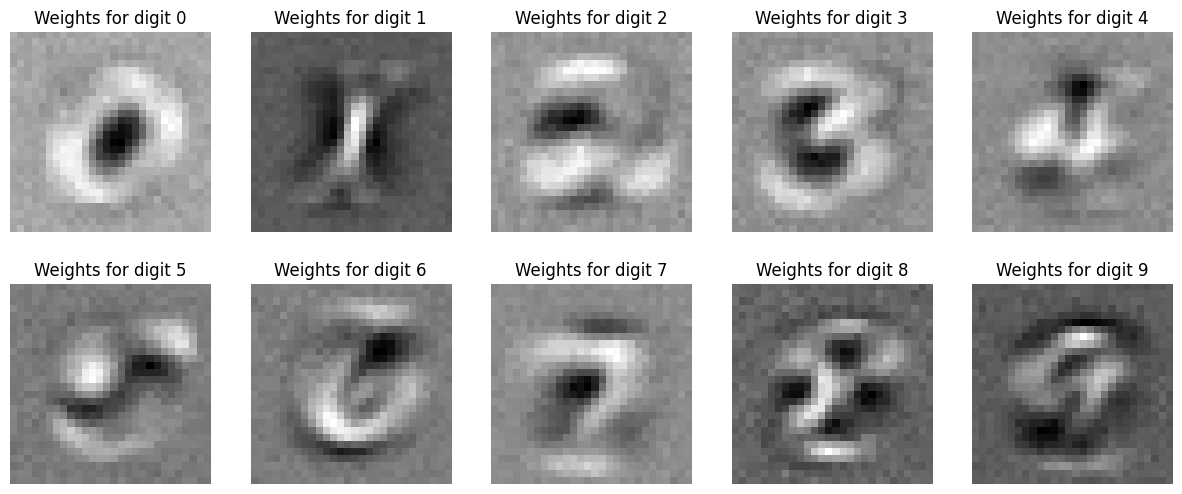

Training with regularization: 0.001
Step: 0/3000, Train Loss: 2.32, Val Loss: 2.31
Step: 100/3000, Train Loss: 1.56, Val Loss: 1.54
Step: 200/3000, Train Loss: 1.20, Val Loss: 1.17
Step: 300/3000, Train Loss: 1.00, Val Loss: 0.98
Step: 400/3000, Train Loss: 0.88, Val Loss: 0.86
Step: 500/3000, Train Loss: 0.80, Val Loss: 0.77
Step: 600/3000, Train Loss: 0.74, Val Loss: 0.72
Step: 700/3000, Train Loss: 0.70, Val Loss: 0.67
Step: 800/3000, Train Loss: 0.66, Val Loss: 0.64
Step: 900/3000, Train Loss: 0.64, Val Loss: 0.61
Step: 1000/3000, Train Loss: 0.61, Val Loss: 0.59
Step: 1100/3000, Train Loss: 0.59, Val Loss: 0.57
Step: 1200/3000, Train Loss: 0.58, Val Loss: 0.55
Step: 1300/3000, Train Loss: 0.56, Val Loss: 0.54
Step: 1400/3000, Train Loss: 0.55, Val Loss: 0.52
Step: 1500/3000, Train Loss: 0.54, Val Loss: 0.51
Step: 1600/3000, Train Loss: 0.53, Val Loss: 0.50
Step: 1700/3000, Train Loss: 0.52, Val Loss: 0.49
Step: 1800/3000, Train Loss: 0.51, Val Loss: 0.48
Step: 1900/3000, Train Los

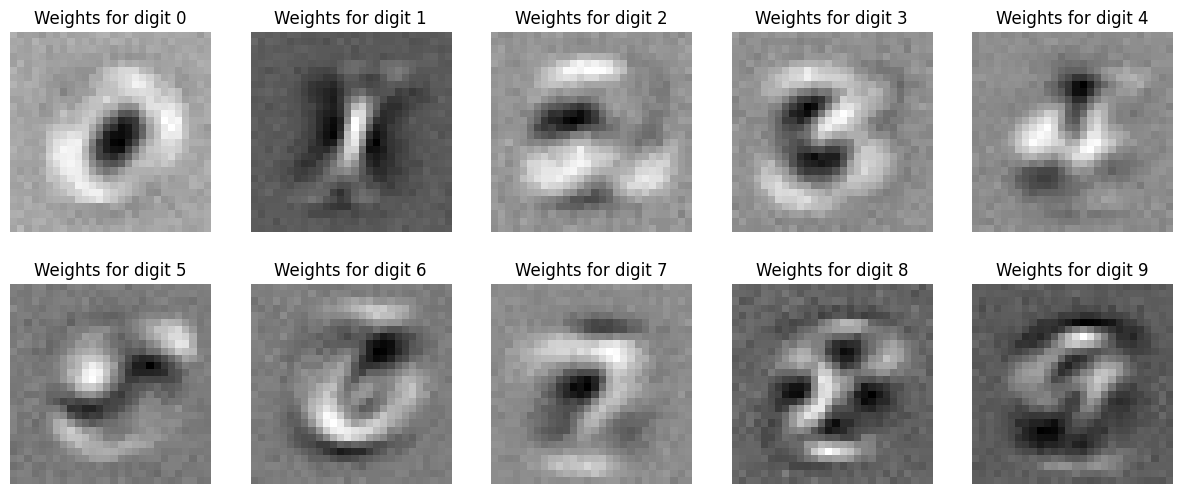

Training with regularization: 0.01
Step: 0/3000, Train Loss: 2.32, Val Loss: 2.31
Step: 100/3000, Train Loss: 1.56, Val Loss: 1.54
Step: 200/3000, Train Loss: 1.20, Val Loss: 1.18
Step: 300/3000, Train Loss: 1.01, Val Loss: 0.98
Step: 400/3000, Train Loss: 0.89, Val Loss: 0.87
Step: 500/3000, Train Loss: 0.81, Val Loss: 0.79
Step: 600/3000, Train Loss: 0.76, Val Loss: 0.73
Step: 700/3000, Train Loss: 0.71, Val Loss: 0.69
Step: 800/3000, Train Loss: 0.68, Val Loss: 0.65
Step: 900/3000, Train Loss: 0.65, Val Loss: 0.63
Step: 1000/3000, Train Loss: 0.63, Val Loss: 0.61
Step: 1100/3000, Train Loss: 0.61, Val Loss: 0.59
Step: 1200/3000, Train Loss: 0.60, Val Loss: 0.57
Step: 1300/3000, Train Loss: 0.58, Val Loss: 0.56
Step: 1400/3000, Train Loss: 0.57, Val Loss: 0.55
Step: 1500/3000, Train Loss: 0.56, Val Loss: 0.53
Step: 1600/3000, Train Loss: 0.55, Val Loss: 0.53
Step: 1700/3000, Train Loss: 0.54, Val Loss: 0.52
Step: 1800/3000, Train Loss: 0.53, Val Loss: 0.51
Step: 1900/3000, Train Loss

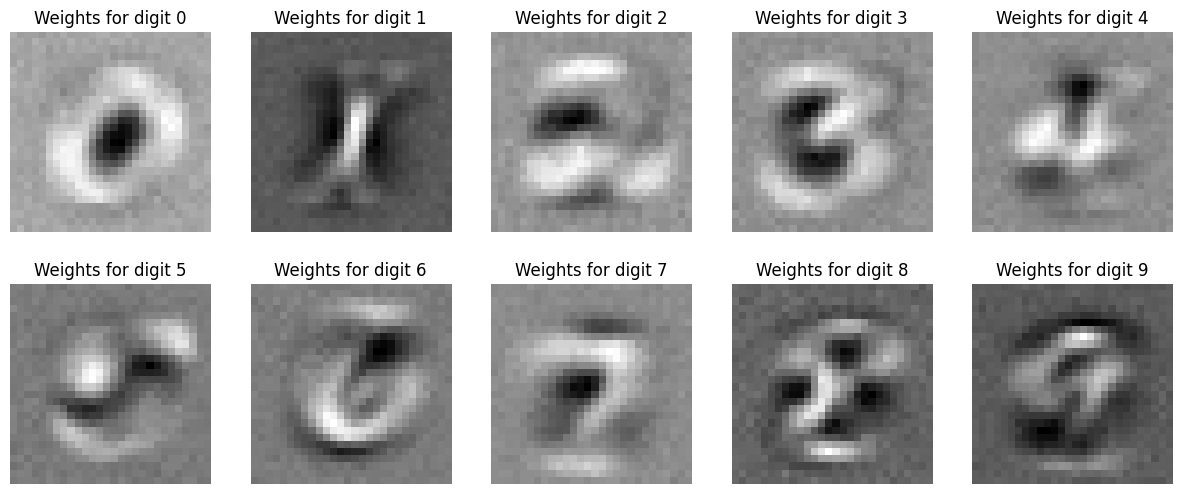

Training with regularization: 0.1
Step: 0/3000, Train Loss: 2.32, Val Loss: 2.31
Step: 100/3000, Train Loss: 1.59, Val Loss: 1.57
Step: 200/3000, Train Loss: 1.26, Val Loss: 1.24
Step: 300/3000, Train Loss: 1.09, Val Loss: 1.07
Step: 400/3000, Train Loss: 0.99, Val Loss: 0.97
Step: 500/3000, Train Loss: 0.93, Val Loss: 0.91
Step: 600/3000, Train Loss: 0.89, Val Loss: 0.87
Step: 700/3000, Train Loss: 0.86, Val Loss: 0.84
Step: 800/3000, Train Loss: 0.84, Val Loss: 0.82
Step: 900/3000, Train Loss: 0.82, Val Loss: 0.80
Step: 1000/3000, Train Loss: 0.81, Val Loss: 0.79
Step: 1100/3000, Train Loss: 0.80, Val Loss: 0.78
Step: 1200/3000, Train Loss: 0.80, Val Loss: 0.77
Step: 1300/3000, Train Loss: 0.79, Val Loss: 0.77
Step: 1400/3000, Train Loss: 0.79, Val Loss: 0.76
Step: 1500/3000, Train Loss: 0.78, Val Loss: 0.76
Step: 1600/3000, Train Loss: 0.78, Val Loss: 0.76
Step: 1700/3000, Train Loss: 0.78, Val Loss: 0.76
Step: 1800/3000, Train Loss: 0.78, Val Loss: 0.75
Step: 1900/3000, Train Loss:

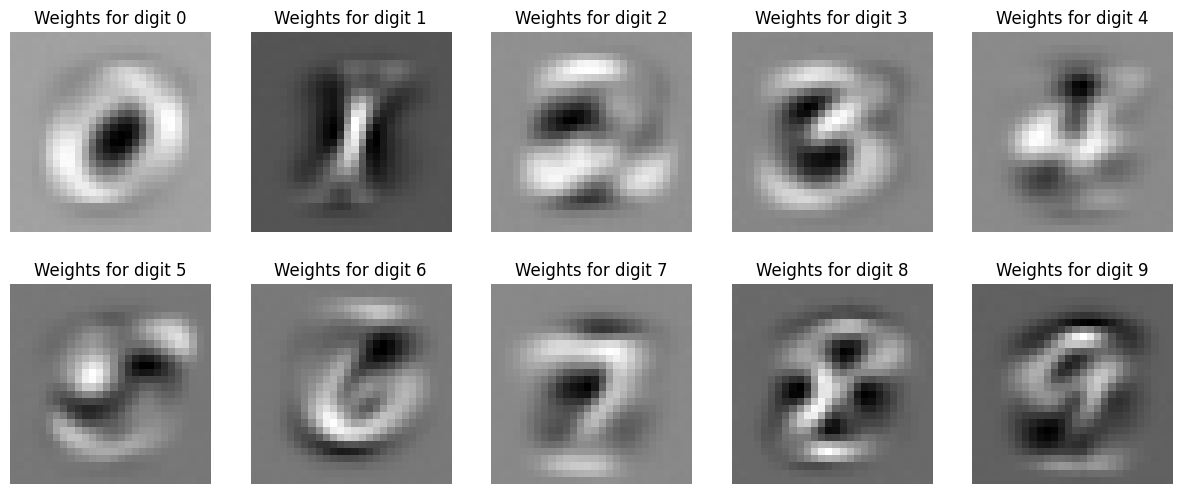

Training with regularization: 1.0
Step: 0/3000, Train Loss: 2.32, Val Loss: 2.31
Step: 100/3000, Train Loss: 1.78, Val Loss: 1.77
Step: 200/3000, Train Loss: 1.67, Val Loss: 1.65
Step: 300/3000, Train Loss: 1.64, Val Loss: 1.63
Step: 400/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 500/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 600/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 700/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 800/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 900/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 1000/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 1100/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 1200/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 1300/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 1400/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 1500/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 1600/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 1700/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 1800/3000, Train Loss: 1.63, Val Loss: 1.62
Step: 1900/3000, Train Loss:

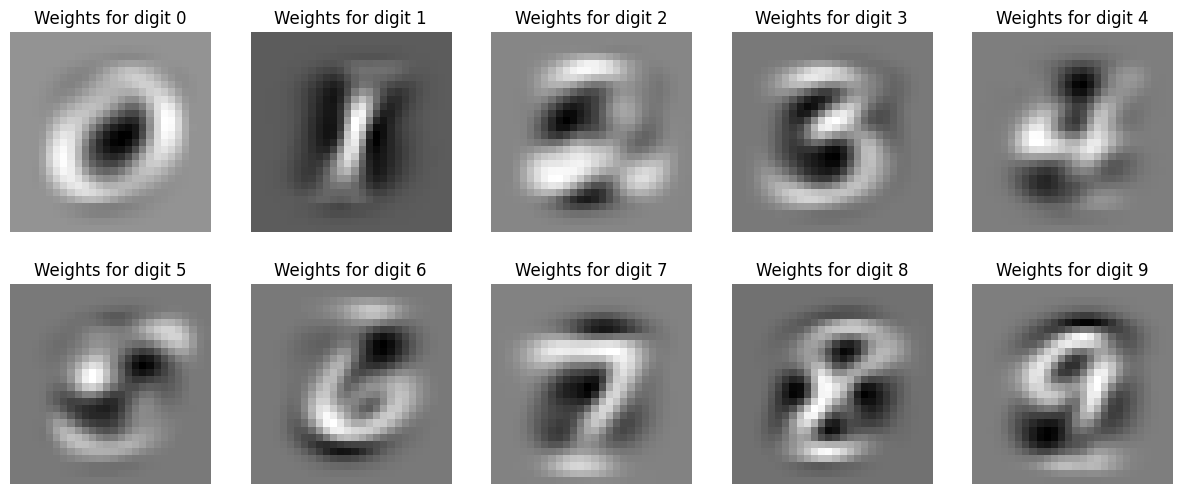

In [16]:
N = X_train.shape[0]
for reg in [0.0, 1e-3, 1e-2, 1e-1, 1.0]:
    print(f"Training with regularization: {reg}")
    model = FCN(configs[0], device=DEVICE)
    model, _, _ = train(model, X_train, yoh_train, X_test, yoh_test, epochs=3000, lr=1e-2, weight_decay=reg, batch_size=N, show_freq=100, dirname="/tmp/checkpoints/part1")
    _, accuracy, recall, precision = evaluate(model, X_test, y_test)
    print(f"Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}\n")
    visualize_weights(model.layers[0].weight.detach().cpu().numpy())

## Part 2

In [43]:
print("=" * 20 + " Part 2 " + "=" * 20)
models = []
accuracies = []
N = X_train.shape[0]
for config, epochs, lr in zip(configs, [2000, 2000, 5000, 5000], [1e-1, 1e-1, 1e-2, 1e-2]):
    print(f"Training config {config}")
    model = FCN(config, device=DEVICE)
    model, train_loss_history, val_loss_history = train(model, X_train, yoh_train, X_test, yoh_test, epochs=epochs, lr=lr, batch_size=N, show_freq=200, dirname="/tmp/checkpoints/part2")
    _, accuracy, recall, precision = evaluate(model, X_test, y_test)
    print(f"Accuracy: {accuracy:.2f}, Recall: {recall}, Precision: {precision}")

    accuracies.append(accuracy)
    models.append(model)

best_model = models[np.argmax(accuracies)]

==================== Part 2 ====================
Training config [784, 10]
Step: 0/2000, Train Loss: 2.32, Val Loss: 2.21
Step: 200/2000, Train Loss: 0.49, Val Loss: 0.47
Step: 400/2000, Train Loss: 0.42, Val Loss: 0.40
Step: 600/2000, Train Loss: 0.38, Val Loss: 0.37
Step: 800/2000, Train Loss: 0.37, Val Loss: 0.35
Step: 1000/2000, Train Loss: 0.35, Val Loss: 0.34
Step: 1200/2000, Train Loss: 0.34, Val Loss: 0.33
Step: 1400/2000, Train Loss: 0.34, Val Loss: 0.32
Step: 1600/2000, Train Loss: 0.33, Val Loss: 0.32
Step: 1800/2000, Train Loss: 0.33, Val Loss: 0.31
saved to /tmp/checkpoints/part2/FCN_784_10_seed=100_optim=SGD_epochs=2000_lr=0.1_weight_decay=0.001_bs=full_scheduler=none_2025-01-14_07-57.pth
Accuracy: 0.92, Recall: [0.97857143 0.97268722 0.87403101 0.90693069 0.93177189 0.85538117
 0.94885177 0.91050584 0.87577002 0.88800793], Precision: [0.94296952 0.95584416 0.92893924 0.8962818  0.90325765 0.90510083
 0.9266055  0.92216749 0.87308086 0.89065606]
Training config [784, 100,